<a href="https://colab.research.google.com/github/treasure-data/td-notebooks/blob/master/machine-learning/electricity/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

This notebook shows how to predict annual electricity consumpsion with Regression in Hivemall.  
As for the dataset, please refer [this page](https://data.cityofchicago.org/Environment-Sustainable-Development/Chicago-Energy-Benchmarking/xq83-jr8c)  

Except for the 1st cell, all you need is to run cells in order.  
The 1st cell requires you to input following information of your Treasure Data account.
- Master API Key
- Existing database name
- Endpoint

# SetUp

Executing a following cell, you are asked to input some information.

In [0]:
from getpass import getpass
td_api_key = getpass('Enter TD API KEY here ')
database   = input('Enter YOUR DATABASE to create tables here ')
assert database, "Error: Input YOUR DATABASE"
endpoint   = input('Enter YOUR ENDPOINT to create tables here (default: "api.treasuredata.com") \nref : https://support.treasuredata.com/hc/en-us/articles/360001474288-Sites-and-Endpoints ')
endpoint = endpoint if endpoint else 'https://api.treasuredata.com/'
endpoint = 'https://' + endpoint if not endpoint.startswith('https://') else endpoint
table = 'electricity'

Enter TD API KEY here ··········
Enter YOUR DATABASE to create tables here hivemall
Enter YOUR ENDPOINT to create tables here (default: "api.treasuredata.com") 
ref : https://support.treasuredata.com/hc/en-us/articles/360001474288-Sites-and-Endpoints 


In [0]:
%%capture
!pip install td-client
!pip install pandas-td
!pip install -q git+https://github.com/takuti/pytd@master#egg=treasure-data[spark]

import numpy as np
import pandas as pd
import pandas_td as td
import matplotlib.pyplot as plt
import seaborn as sns
import pytd
import tdclient
pd.options.display.max_columns = 30

%matplotlib inline
con = td.connect(apikey=td_api_key, endpoint=endpoint)
c = tdclient.Client(apikey=td_api_key, endpoint=endpoint)
presto = td.create_engine('presto:{}'.format(database), con=con)
hive = td.create_engine('hive:{}'.format(database), con=con)

def recreate_table(client, table, database=database):
  if table in [table.name for table in client.tables(database)]:
    client.delete_table(database, table)
  client.create_log_table(database, table)
  return None

# Data Preparation

A cell below will create a table on your Treasure Data account.  

In [0]:
df = pd.read_json('https://data.cityofchicago.org/resource/pvq4-8f4k.json').set_index('id')
df = df.where((pd.notnull(df)), None)

In [0]:
try:
  client = pytd.Client(database=database, apikey=td_api_key)
  client.load_table_from_dataframe(df.reset_index(), '{}.{}'.format(database, table), if_exists='overwrite')
except Exception as e:
  print('This operation will take around 5 minutes...')
  if table in [table.name for table in c.tables(database)]:
    c.delete_table(database, table)
  td.to_td(df, '{}.{}'.format(database, table), con)
  while columns > 1:
    time.sleep(60)
    columns = td.read_td_query('''select * from electricity limit 1''', engine=presto).shape[1]

Check the table

In [0]:
td.read_td_query('''
select 
  *
from 
  electricity
limit 2
''', engine=presto)

,computed_region_43wa_7qmu,community_area,computed_region_awaf_s7ux,ghg_intensity_kg_co2e_sq_ft,latitude,computed_region_vrxf_vc4k,zip_code,property_name,gross_floor_area_buildings_sq_ft,source_eui_kbtu_sq_ft,id,site_eui_kbtu_sq_ft,longitude,address,weather_normalized_source_eui_kbtu_sq_ft,primary_property_type,data_year,weather_normalized_site_eui_kbtu_sq_ft,natural_gas_use_kbtu,energy_star_score,computed_region_bdys_3d7i,of_buildings,computed_region_6mkv_f3dw,location,year_built,electricity_use_kbtu,total_ghg_emissions_metric_tons_co2e,district_chilled_water_use_kbtu,district_steam_use_kbtu,time
0,33,HYDE PARK,32,24.8,41.789621,8,60637,Kent Chemical Laboratory,59841,428.1,252053,288.4,-87.597784,1020-24 East 58th Street,430.2,Laboratory,2015,289.4,NaN,NaN,154,1,22260,"{""coordinates"":[-87.597784,41.789621],""type"":""...",1894,3034181.0,1485.0,5029800.0,9193621.0,1555038967
1,23,NEAR WEST SIDE,48,7.9,41.877185,29,60607,333 South Ashland,68150,136.6,175475,81.0,-87.666647,333 S. Ashland Avenue,140.8,Office,2015,85.6,3842743.0,76.0,91,1,14917,"{""coordinates"":[-87.666647,41.877185],""type"":""...",1927,1679731.0,542.0,NaN,NaN,1555038967


Please see [this page](https://data.cityofchicago.org/Environment-Sustainable-Development/Chicago-Energy-Benchmarking/xq83-jr8c) to get to know the meaning of each columns.

# EDA (Explore Data Analysis)
Before running machine learning tasks, you should understand your data correctly.  
Descriptive statistics and visualization are important for this.

A target variable is `electricity_use_kbtu` .   

## Data Size

In [0]:
td.read_td_query('''
select
  count(*)
from
  electricity
''', engine=presto)

,_col0
0,1000


## Check if null value exists

In [0]:
td.read_td_query('''
select
  count(computed_region_43wa_7qmu) as computed_region_43wa_7qmu,
  count(community_area) as community_area,
  count(computed_region_awaf_s7ux) as computed_region_awaf_s7ux,
  count(ghg_intensity_kg_co2e_sq_ft) as ghg_intensity_kg_co2e_sq_ft,
  count(latitude) as latitude,
  count(computed_region_vrxf_vc4k) as computed_region_vrxf_vc4k,
  count(zip_code) as zip_code,
  count(property_name) as property_name,
  count(gross_floor_area_buildings_sq_ft) as gross_floor_area_buildings_sq_ft,
  count(source_eui_kbtu_sq_ft) as source_eui_kbtu_sq_ft,
  count(id) as id,
  count(site_eui_kbtu_sq_ft) as site_eui_kbtu_sq_ft,
  count(longitude) as longitude,
  count(address) as address,
  count(weather_normalized_source_eui_kbtu_sq_ft) as weather_normalized_source_eui_kbtu_sq_ft,
  count(primary_property_type) as primary_property_type,
  count(data_year) as data_year,
  count(weather_normalized_site_eui_kbtu_sq_ft) as weather_normalized_site_eui_kbtu_sq_ft,
  count(natural_gas_use_kbtu) as natural_gas_use_kbtu,
  count(energy_star_score) as energy_star_score,
  count(computed_region_bdys_3d7i) as computed_region_bdys_3d7i,
  count(of_buildings) as of_buildings,
  count(computed_region_6mkv_f3dw) as computed_region_6mkv_f3dw,
  count(location) as location,
  count(year_built) as year_built,
  count(electricity_use_kbtu) as electricity_use_kbtu,
  count(total_ghg_emissions_metric_tons_co2e) as total_ghg_emissions_metric_tons_co2e,
  count(district_chilled_water_use_kbtu) as district_chilled_water_use_kbtu,
  count(district_steam_use_kbtu) as district_steam_use_kbtu
from
  electricity
''', engine=presto).transpose().sort_values(0)

,0
district_chilled_water_use_kbtu,44
district_steam_use_kbtu,47
energy_star_score,836
natural_gas_use_kbtu,868
weather_normalized_site_eui_kbtu_sq_ft,968
weather_normalized_source_eui_kbtu_sq_ft,968
ghg_intensity_kg_co2e_sq_ft,979
total_ghg_emissions_metric_tons_co2e,980
source_eui_kbtu_sq_ft,986
site_eui_kbtu_sq_ft,986


## Target Variable

Average / Min / Max / Percentile

In [0]:
td.read_td_query('''
select
  avg(electricity_use_kbtu) as mean
  ,min(electricity_use_kbtu) as min
  ,approx_percentile(electricity_use_kbtu, 0.25) as q25
  ,approx_percentile(electricity_use_kbtu, 0.50) as q50
  ,approx_percentile(electricity_use_kbtu, 0.75) as q75
  ,max(electricity_use_kbtu) as max
from
  electricity
where
  electricity_use_kbtu is not null
''', engine=presto)

,mean,min,q25,q50,q75,max
0,1.577446e+07,214.0,2328835.0,5657618.0,12959963.0,485542954.0


Histgram

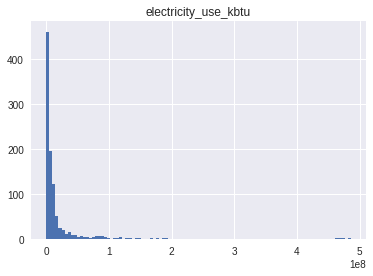

In [0]:
td.read_td_query('''
select
  electricity_use_kbtu
from
  electricity
''', engine=presto).hist(bins=100);

Most of data exist aound zero. In the case, you should try logarithmic transformation.  
It might convert the data into Gaussian distribution, which is easy to predict.

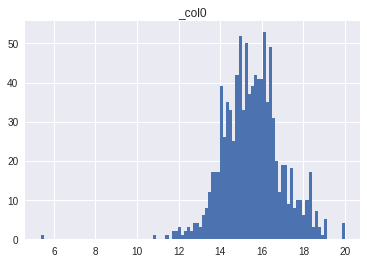

In [0]:
td.read_td_query('''
select
  ln(electricity_use_kbtu)
from
  electricity
''', engine=presto).hist(bins=100);

## Features

Following variable are unavailable as features because they are unique for each rows.
- zip_code
- property_name
- address
- id
  
To simplify this tutrial, following variable are not used.
- natural_gas_use_kbtu
- district_chilled_water_use_kbtu	
- district_steam_use_kbtu
- source_eui_kbtu_sq_ft
- site_eui_kbtu_sq_ft
- weather_normalized_source_eui_kbtu_sq_ft
- weather_normalized_site_eui_kbtu_sq_ft
- district_chilled_water_use_kbtu
- district_steam_use_kbtu

Finally, the rest is available as features.
- computed_region_43wa_7qmu
- computed_region_awaf_s7ux
- ghg_intensity_kg_co2e_sq_ft
- latitude
- computed_region_vrxf_vc4k
- gross_floor_area_buildings_sq_ft
- source_eui_kbtu_sq_ft
- longitude
- address
- primary_property_type
- data_year
- energy_star_score
- computed_region_bdys_3d7i
- of_buildings
- computed_region_6mkv_f3dw
- location
- year_built
- total_ghg_emissions_metric_tons_co2e
- community_area
- primary_property_type


### Qunatitative variables

At first, check the correlation coefficients for each variable pairs.  
Only variables with high coefficients are used at training step.

Also, the data has `data_year` and `year_built`, so the age of buildings can be calculated by `data_year - year_build`.

age                                    -0.313709
data_year                              -0.307917
energy_star_score                      -0.260563
computed_region_bdys_3d7i              -0.163200
computed_region_6mkv_f3dw              -0.048395
computed_region_vrxf_vc4k              -0.029124
latitude                               -0.017687
of_buildings                            0.062106
computed_region_awaf_s7ux               0.074297
computed_region_43wa_7qmu               0.111158
longitude                               0.114300
year_built                              0.306125
ghg_intensity_kg_co2e_sq_ft             0.311522
total_ghg_emissions_metric_tons_co2e    0.566072
gross_floor_area_buildings_sq_ft        0.567623
electricity_use_kbtu                    1.000000
Name: electricity_use_kbtu, dtype: float64


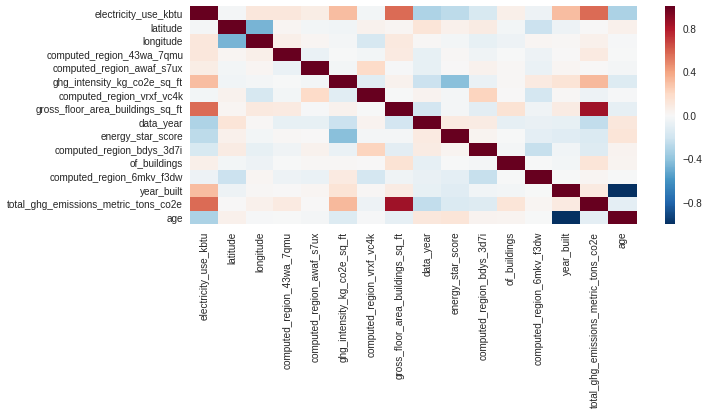

In [0]:
import seaborn as sns
d = td.read_td_query('''
select
  ln(electricity_use_kbtu) as electricity_use_kbtu,
  latitude,
  longitude,
  location,
  computed_region_43wa_7qmu,
  computed_region_awaf_s7ux,
  ghg_intensity_kg_co2e_sq_ft,
  computed_region_vrxf_vc4k,
  gross_floor_area_buildings_sq_ft,
  primary_property_type,
  data_year,
  energy_star_score,
  computed_region_bdys_3d7i,
  of_buildings,
  computed_region_6mkv_f3dw,
  year_built,
  total_ghg_emissions_metric_tons_co2e,
  data_year - year_built as age
from
  electricity
''', engine=presto)
fig, ax = plt.subplots(figsize=(10,4))
sns.heatmap(d.corr(), ax=ax);

print(d.corr().loc['electricity_use_kbtu',:].sort_values())

From the result, following variables are selected.
- age
- energy_star_score
- gross_floor_area_buildings_sq_ft
- ghg_intensity_kg_co2e_sq_ft

Note:
- `total_ghg_emissions_metric_tons_co2e` and `data_year` has high correlation coefficient with `ghg_intensity_kg_co2e_sq_ft` and `age` respectively, so they might be not necessary.

#### age

Check whether null exists

In [0]:
td.read_td_query('''
select
  count(data_year) as data_year
  ,count(year_built) as year_build
  ,count(*)
from
  electricity
''', engine=presto)

,data_year,year_build,_col2
0,1000,1000,1000


In [0]:
td.read_td_query('''
select
  avg(data_year - year_built) as mean
  ,min(data_year - year_built) as min
  ,approx_percentile(data_year - year_built, 0.25) as q25
  ,approx_percentile(data_year - year_built, 0.50) as q50
  ,approx_percentile(data_year - year_built, 0.75) as q75
  ,max(data_year - year_built) as max
from
  electricity
''', engine=presto)

,mean,min,q25,q50,q75,max
0,51.592,1,17,46,88,157


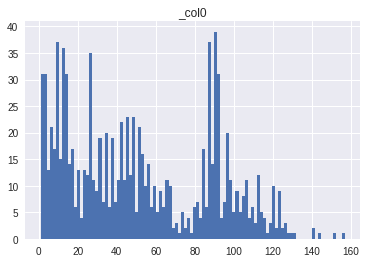

In [0]:
td.read_td_query('''
select
  data_year - year_built
from
  electricity
''', engine=presto).hist(bins=100);

####  energy_star_score

Check whether null exists

In [0]:
td.read_td_query('''
select
  count(energy_star_score)
  ,count(*)
from
  electricity
''', engine=presto)

,_col0,_col1
0,836,1000


164 null values exist.

In [0]:
td.read_td_query('''
select
  avg(energy_star_score) as average
  ,min(energy_star_score) as min
  ,approx_percentile(energy_star_score, 0.25) as pct_25th
  ,approx_percentile(energy_star_score, 0.50) as pct_50th
  ,approx_percentile(energy_star_score, 0.75) as pct_75th
  ,max(energy_star_score) as max
from
  electricity
''', engine=presto)

,average,min,pct_25th,pct_50th,pct_75th,max
0,58.352871,1.0,36.0,62.0,82.0,100.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff144757f60>]],
      dtype=object)

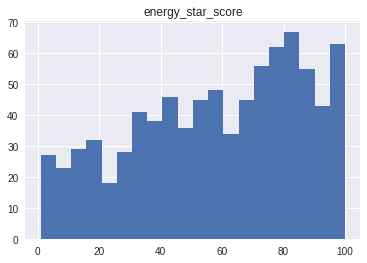

In [0]:
td.read_td_query('''
  select
    energy_star_score
  from
    electricity
''', engine=presto).hist(bins=20)

#### gross_floor_area_buildings_sq_ft

Check whether null exists

In [0]:
td.read_td_query('''
select
  count(gross_floor_area_buildings_sq_ft)
  ,count(*)
from
  electricity
''', engine=presto)

,_col0,_col1
0,1000,1000


In [0]:
td.read_td_query('''
select
  avg(gross_floor_area_buildings_sq_ft) as average
  ,min(gross_floor_area_buildings_sq_ft) as min
  ,approx_percentile(gross_floor_area_buildings_sq_ft, 0.25) as pct_25th
  ,approx_percentile(gross_floor_area_buildings_sq_ft, 0.50) as pct_50th
  ,approx_percentile(gross_floor_area_buildings_sq_ft, 0.75) as pct_75th
  ,max(gross_floor_area_buildings_sq_ft) as max
from
  electricity
''', engine=presto)

,average,min,pct_25th,pct_50th,pct_75th,max
0,307898.905,50000,79347,145920,325968,9245333


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1446851d0>]],
      dtype=object)

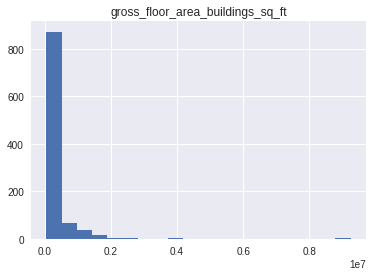

In [0]:
td.read_td_query('''
  select
    gross_floor_area_buildings_sq_ft
  from
    electricity
''', engine=presto).hist(bins=20)

This chart show that the most of the data exists aounrd small values, same as the target variable.  
So, let's check the correlation using logarithmic converted one.

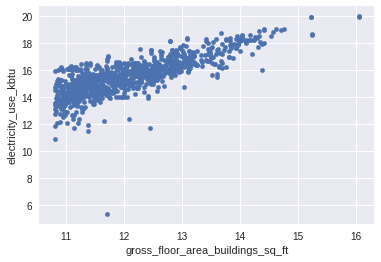

In [0]:
td.read_td_query('''
  select
    ln(electricity_use_kbtu) as electricity_use_kbtu,
    ln(gross_floor_area_buildings_sq_ft) as gross_floor_area_buildings_sq_ft
  from
    electricity
''', engine=presto).plot.scatter(x='gross_floor_area_buildings_sq_ft', y='electricity_use_kbtu');

#### ghg_intensity_kg_co2e_sq_ft

Check whether null exists

In [0]:
td.read_td_query('''
select
  count(ghg_intensity_kg_co2e_sq_ft)
  ,count(*)
from
  electricity
''', engine=presto)

,_col0,_col1
0,979,1000


21 null values exist.

In [0]:
td.read_td_query('''
select
  avg(ghg_intensity_kg_co2e_sq_ft) as average
  ,min(ghg_intensity_kg_co2e_sq_ft) as min
  ,approx_percentile(ghg_intensity_kg_co2e_sq_ft, 0.25) as pct_25th
  ,approx_percentile(ghg_intensity_kg_co2e_sq_ft, 0.50) as pct_50th
  ,approx_percentile(ghg_intensity_kg_co2e_sq_ft, 0.75) as pct_75th
  ,max(ghg_intensity_kg_co2e_sq_ft) as max
from
  electricity
''', engine=presto)

,average,min,pct_25th,pct_50th,pct_75th,max
0,11.789683,0.2,6.6,8.8,13.06,309.7


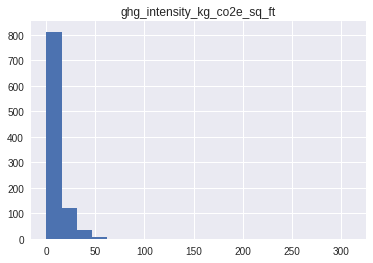

In [0]:
td.read_td_query('''
  select
    ghg_intensity_kg_co2e_sq_ft
  from
    electricity
''', engine=presto).hist(bins=20);

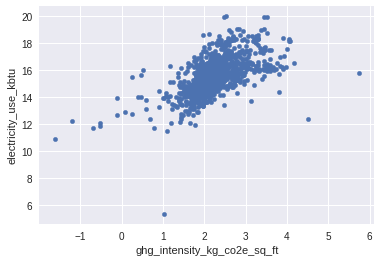

In [0]:
td.read_td_query('''
  select
    ln(electricity_use_kbtu) as electricity_use_kbtu,
    ln(ghg_intensity_kg_co2e_sq_ft) as ghg_intensity_kg_co2e_sq_ft
  from
    electricity
''', engine=presto).plot.scatter(x='ghg_intensity_kg_co2e_sq_ft', y='electricity_use_kbtu');

### Category features

Check the following categorical features.
- community_area
- primary_property_type

#### community_area

In [0]:
d = td.read_td_query('''
  select
    community_area
    ,count(*) as n
    ,avg(ln(electricity_use_kbtu)) as electricity_use_kbtu_avg
  from
    electricity
  group by
    1
''', engine=presto, index_col='community_area').sort_values('n', ascending=False)

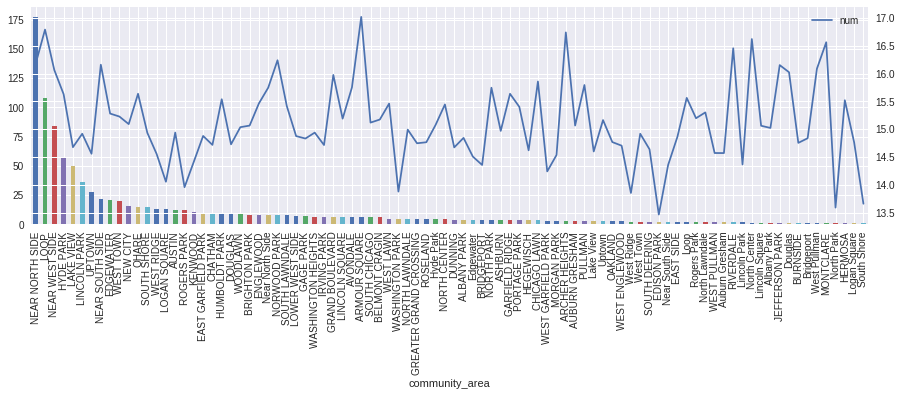

In [0]:
fig, ax = plt.subplots(figsize=(15,4))
d['n'].plot.bar(ax=ax)
_ax = ax.twinx()
d['electricity_use_kbtu_avg'].plot(ax=_ax)
plt.legend(['num', 'avg_ln_target']);

Only `NEAR NORTH SIDE`, `LOOP`, `NEAR WEST SIDE` seems to have enough samples.  
The rest of values are treated as `others`.

#### primary_property_type

In [0]:
d = td.read_td_query('''
  select
    primary_property_type
    ,count(*) as n
    ,avg(ln(electricity_use_kbtu)) as electricity_use_kbtu_avg
  from
    electricity
  group by
    1
''', engine=presto, index_col='primary_property_type').sort_values('n', ascending=False)

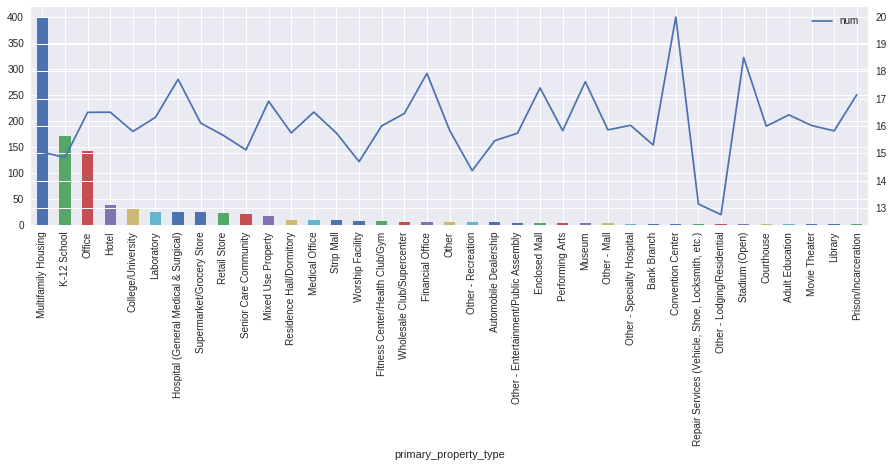

In [0]:
fig, ax = plt.subplots(figsize=(15,4))
d['n'].plot.bar(ax=ax)
_ax = ax.twinx()
d['electricity_use_kbtu_avg'].plot(ax=_ax)
plt.legend(['num', 'avg_ln_target']);

Same as above, features expcept for  `Multifamily Housing`, `K-12 School` and `Office` are treated as `others`

# Machine learning

## Preprocess

### Fill and remove null

Some columns have null values, so they are neccessary to fill with some values.  
In this tutrial, we use average values for each columns with null.  

Also, the target value, `electricity_use_kbtu` has some null values,  so they are necessary to remove.

In [0]:
recreate_table(c, 'electricity_fillna_with_avg')

In [0]:
td.read_td_query('''
insert into electricity_fillna_with_avg

with averages as (
  select
    avg(energy_star_score) as avg_energy_star_score
    ,avg(ln(ghg_intensity_kg_co2e_sq_ft)) as avg_ghg_intensity_kg_co2e_sq_ft
  from
    electricity
)

select
  id
  ,ln(electricity_use_kbtu) as electricity_use_kbtu
  ,data_year - year_built as age
  ,coalesce(energy_star_score, avg_energy_star_score) as energy_star_score
  ,ln(gross_floor_area_buildings_sq_ft) as gross_floor_area_buildings_sq_ft
  ,coalesce(ln(ghg_intensity_kg_co2e_sq_ft), avg_ghg_intensity_kg_co2e_sq_ft) as ghg_intensity_kg_co2e_sq_ft
  ,case when community_area in ('NEAR NORTH SIDE', 'LOOP', 'NEAR WEST SIDE') then community_area else 'others' end as community_area
  ,case when primary_property_type in ('Multifamily Housing', 'K-12 School', 'Office') then primary_property_type else 'others' end as primary_property_type
from
  electricity
  full outer join
  averages
  on 1=1
where
  electricity_use_kbtu is not null
''', engine=presto)

,rows
0,990


Check the created table

In [0]:
td.read_td_query('''
select
  *
from
  electricity_fillna_with_avg
limit 2
''', engine=presto)

,id,electricity_use_kbtu,age,energy_star_score,gross_floor_area_buildings_sq_ft,ghg_intensity_kg_co2e_sq_ft,community_area,primary_property_type,time
0,252053,14.925452,121,58.352871,10.999446,3.210844,others,others,1555551583
1,175475,14.334144,88,76.000000,11.129466,2.066863,NEAR WEST SIDE,Office,1555551583


### Rescale quantitative features
Rescaling quantitative features is one of basic approaches to improve accuracy.

In [0]:
recreate_table(c, 'electricity_rescaled_features')

In [0]:
td.read_td_query('''
  with stats as (
    select
      avg(age) as age_avg
      ,stddev(age) as age_stddev
      ,avg(energy_star_score) as energy_star_score_avg
      ,stddev(energy_star_score) as energy_star_score_stddev
      ,avg(gross_floor_area_buildings_sq_ft) as gross_floor_area_buildings_sq_ft_avg
      ,stddev(gross_floor_area_buildings_sq_ft) as gross_floor_area_buildings_sq_ft_stddev
      ,avg(ghg_intensity_kg_co2e_sq_ft) as ghg_intensity_kg_co2e_sq_ft_avg
      ,stddev(ghg_intensity_kg_co2e_sq_ft) as ghg_intensity_kg_co2e_sq_ft_stddev
    from
      electricity_fillna_with_avg
  )

  insert into table electricity_rescaled_features
  select
    id
    ,electricity_use_kbtu
    ,zscore(age, age_avg, age_stddev) as age
    ,zscore(energy_star_score, energy_star_score_avg, energy_star_score_stddev) as energy_star_score
    ,zscore(gross_floor_area_buildings_sq_ft, gross_floor_area_buildings_sq_ft_avg, gross_floor_area_buildings_sq_ft_stddev) as gross_floor_area_buildings_sq_ft
    ,zscore(ghg_intensity_kg_co2e_sq_ft, ghg_intensity_kg_co2e_sq_ft_avg, ghg_intensity_kg_co2e_sq_ft_stddev) as ghg_intensity_kg_co2e_sq_ft
    ,community_area
    ,primary_property_type
  from
    electricity_fillna_with_avg
    full outer join
    stats
    on 1=1
''', engine=hive);

### Convert Hivemall format

Aggregate features into an array column ( `features` ).  
Quantitative features and categorical ones are necessary to be preprocess separately as below.

Also, data should be splitted into training data and test data in order to prevent overfitting.  
Here, the ratio of training data and test data are put 80% and 20% respectively.

In [0]:
recreate_table(c, 'electricity_train')

In [0]:
td.read_td_query('''
  insert into table electricity_train 
  select
    id
    ,case when rand() < 0.8 then 0 else 1 end as is_test
    ,electricity_use_kbtu
    ,array_concat(
        quantitative_features(array('age', 'energy_star_score', 'gross_floor_area_buildings_sq_ft', 'ghg_intensity_kg_co2e_sq_ft'),
          age, energy_star_score, gross_floor_area_buildings_sq_ft, ghg_intensity_kg_co2e_sq_ft)
        ,categorical_features(array('community_area', 'primary_property_type'), 
          community_area, primary_property_type) 
    ) as features
    ,quantitative_features(array('age', 'energy_star_score', 'gross_floor_area_buildings_sq_ft', 'ghg_intensity_kg_co2e_sq_ft'),
      age, energy_star_score, gross_floor_area_buildings_sq_ft, ghg_intensity_kg_co2e_sq_ft) as quantitative_features
    ,categorical_features(array('community_area', 'primary_property_type'), 
      community_area, primary_property_type) as categorical_features
  from
    electricity_rescaled_features
''', engine=hive);

Check the created table.

In [0]:
td.read_td_query('''
  select
    *
  from
    electricity_train
  limit 2
''', engine=presto)

,id,is_test,electricity_use_kbtu,features,quantitative_features,categorical_features,time
0,160347,0,16.135262,"[age:-1.1577204465866089, energy_star_score:-0...","[age:-1.1577204465866089, energy_star_score:-0...","[community_area#LOOP, primary_property_type#Mu...",1555553524
1,251996,0,15.834571,"[age:-1.103179931640625, energy_star_score:1.5...","[age:-1.103179931640625, energy_star_score:1.5...","[community_area#others, primary_property_type#...",1555553524


Aside from this, check the records of training data and test data.

In [0]:
td.read_td_query('''
  select
    is_test
    ,count(*) as n
  from
    electricity_train
  group by
    1
''', engine=presto)

,is_test,n
0,1,189
1,0,801


## Build a logistic regression model

In [0]:
recreate_table(c, 'electricity_model')

In [0]:
td.read_td_query('''
insert overwrite table electricity_model
select
  train_regressor(
    add_bias(features), electricity_use_kbtu, 
    '-loss squaredloss -opt AdamHD -reg l2'
  ) as (feature,weight)
from
  electricity_train
where
  is_test = 0
''', engine=hive);

Check the result in reverse order of weights.

In [0]:
td.read_td_query('''
select
  feature, weight
from
  electricity_model
order by
  weight desc
''', engine=presto)

,feature,weight
0,0,8.012382
1,primary_property_type#Office,3.967558
2,community_area#LOOP,3.874713
3,community_area#NEAR WEST SIDE,3.872687
4,community_area#NEAR NORTH SIDE,3.852142
5,primary_property_type#others,3.804410
6,primary_property_type#K-12 School,3.749833
7,community_area#others,3.671014
8,primary_property_type#Multifamily Housing,3.508818
9,gross_floor_area_buildings_sq_ft,1.010666


## Prediction

In [0]:
recreate_table(c, 'electricity_predicted')

In [0]:
td.read_td_query('''
with parsed as (
  select
    id
    ,is_test
    ,electricity_use_kbtu
    ,extract_feature(feature) as feature
    ,extract_weight(feature) as value
  from
    electricity_train
  lateral view
    explode(add_bias(features)) t as feature
)

insert overwrite table electricity_predicted
select
  id
  ,is_test
  ,electricity_use_kbtu
  ,sum(value * weight) as pred
from
  parsed
  inner join
  electricity_model model
  on
    parsed.feature = model.feature
group by
  1,2,3
''', engine=hive);

Check the created table.

In [0]:
td.read_td_query('''
select
  *
from
  electricity_predicted
limit 5
''', engine=presto)

,id,is_test,electricity_use_kbtu,pred,time
0,100068,0,15.724874,15.321088,1555556830
1,100252,1,14.288557,13.732631,1555556830
2,100256,0,17.156712,16.735895,1555556830
3,100256,0,17.393256,16.932497,1555556830
4,100317,0,13.213417,13.831594,1555556830


## Evaluation

When handling regression tasks, MSE or RMSE is often used for evaluation.  Let's calculate these values.  
  
**Note:**   
When building a model, the logarithmic transformation was applied for the target variable.  So, exponentail transformation should be applied for both the target variable and predicted values.

In [0]:
td.read_td_query('''
select
  is_test
  ,mse(exp(electricity_use_kbtu), exp(pred)) as mse_logarithmic_scale
  ,rmse(exp(electricity_use_kbtu), exp(pred)) as rmse_logarithmic_scale
  ,mse(electricity_use_kbtu, pred) as mse_original_scale
  ,rmse(electricity_use_kbtu, pred) as rmse_original_scale
from
  electricity_predicted
group by
  1
''', engine=hive)

,is_test,mse_logarithmic_scale,rmse_logarithmic_scale,mse_original_scale,rmse_original_scale
0,0,6.110162e+13,7.816752e+06,0.268329,0.518005
1,1,3.629974e+13,6.024927e+06,0.274002,0.523452


When evaluating,  you should scatter plot of target values and predicted values.

#### Logarithmic Scale

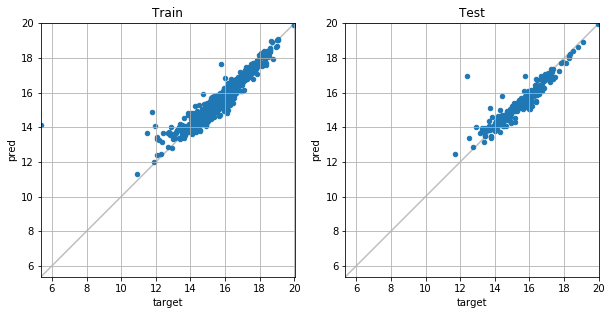

In [0]:
# Get min and max
df_min_max = td.read_td_query('''
select
  least(min(electricity_use_kbtu), min(pred)) as min
  ,greatest(max(electricity_use_kbtu), max(pred)) as max
from
  electricity_predicted
''', engine=presto)
lims = [df_min_max['min'][0], df_min_max['max'][0]]

# Plot
fig, axes = plt.subplots(1,2, figsize=(10,5))
for i, ax in enumerate(axes):
  td.read_td_query('''
  select
    electricity_use_kbtu as target,
    pred as pred
  from
    electricity_predicted
  where
    is_test = {}
  '''.format(i), engine=presto).plot.scatter(x='target', y='pred', ax=ax)
  ax.plot(lims, lims, 'k-', zorder=0, color='gray', alpha=0.5)
  ax.set_aspect('equal')
  ax.set_xlim(lims)
  ax.set_ylim(lims)
  ax.grid(True)
  ax.set_title('Train' if i == 0 else 'Test')
plt.show();

#### Original Scale

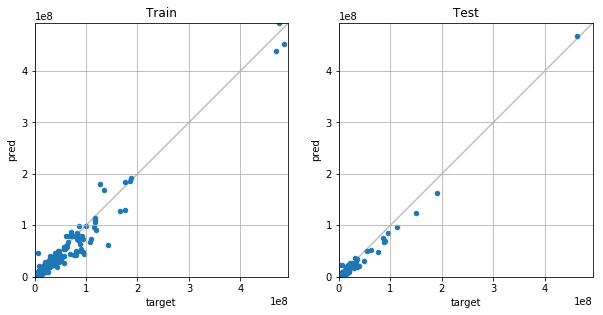

In [0]:
# Get min and max
df_min_max = td.read_td_query('''
select
  least(min(exp(electricity_use_kbtu)), min(exp(pred))) as min
  ,greatest(max(exp(electricity_use_kbtu)), max(exp(pred))) as max
from
  electricity_predicted
''', engine=presto)
lims = [df_min_max['min'][0], df_min_max['max'][0]]

# Plot
fig, axes = plt.subplots(1,2, figsize=(10,5))
for i, ax in enumerate(axes):
  td.read_td_query('''
  select
    exp(electricity_use_kbtu) as target,
    exp(pred) as pred
  from
    electricity_predicted
  where
    is_test = {}
  '''.format(i), engine=presto).plot.scatter(x='target', y='pred', ax=ax)
  ax.plot(lims, lims, 'k-', zorder=0, color='gray', alpha=0.5)
  ax.set_aspect('equal')
  ax.set_xlim(lims)
  ax.set_ylim(lims)
  ax.grid(True)
  ax.set_title('Train' if i == 0 else 'Test')
plt.show();

# Discussion

Seeing the result above, the model seems to work to some extent because the dots are around `y=x`.  
Possible approaches to improve is to add features not used this time, to increase values of categorical features and so on.